<h1>Simulation examples for the paper "Convergence of Langevin-Simulated Annealing algorithms with multiplicative noise
"</h1>
https://arxiv.org/abs/2109.11669

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from optimizers import *
from schedules import *
from callbacks import *

Load the MNIST dataset and normalize it.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

<h3>Comparing Langevin algorithms on a neural network with two hidden layers</h3>

Define the model, the schedules and the optimizers.

In [3]:
def get_model(optimizer):
    model = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
    ])
    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model


epoch_change = 5
batch_size = 32
STEPS_PER_EPOCH = int(x_train.shape[0]/batch_size)

lr_schedule1 = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001, decay_steps=epoch_change*STEPS_PER_EPOCH, decay_rate=1., staircase=False, name=None)

lr_schedule2 = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01, decay_steps=epoch_change*STEPS_PER_EPOCH, decay_rate=1., staircase=False, name=None)

lr_schedule3 = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1, decay_steps=epoch_change*STEPS_PER_EPOCH, decay_rate=1., staircase=False, name=None)

sigma_schedule = InverseRLogDecay(
    initial_learning_rate=0.002, decay_steps=epoch_change*STEPS_PER_EPOCH, decay_rate=1., staircase=False, name=None)

optimizers = [SGLDOptimizer(learning_rate=lr_schedule2, sigma=sigma_schedule),
              pSGLDOptimizer(learning_rate=lr_schedule1, sigma=sigma_schedule, alpha=0.95, diagonal_bias=1e-6),
              aSGLDOptimizer(learning_rate=lr_schedule1, sigma=sigma_schedule, beta_1=0.95, beta_2=0.999, diagonal_bias=1e-6),
              pAdaSGLDOptimizer(learning_rate=lr_schedule3, sigma=sigma_schedule, beta_1=0.95, beta_2=0.95, diagonal_bias=1e-4),
             ]

Get a model for the first time and save its weights, so that to make all the models start with the same initial condition.

In [4]:
model = get_model('adam')
eval_train_init = model.evaluate(x_train, y_train, batch_size=32, verbose=0)
eval_test_init = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
model.save_weights('./MNIST_intial_checkpoint')

Train the model with different optimizers.

In [5]:
EPOCHS = 10
models = {}
histories = {}
for optimizer in optimizers:
    models[optimizer] = get_model(optimizer)
    models[optimizer].load_weights('./MNIST_intial_checkpoint')
    histories[optimizer] = models[optimizer].fit(x_train, y_train, batch_size=batch_size, epochs=EPOCHS,
                  validation_data=(x_test, y_test), verbose=0)
    print('Finished training for optimizer {}'.format(type(optimizer).__name__))

Finished training for optimizer SGLDOptimizer
Finished training for optimizer pSGLDOptimizer
Finished training for optimizer aSGLDOptimizer
Finished training for optimizer pAdaSGLDOptimizer


Plot the results with the train loss, the train accuracy, the test loss and the test accuracy.

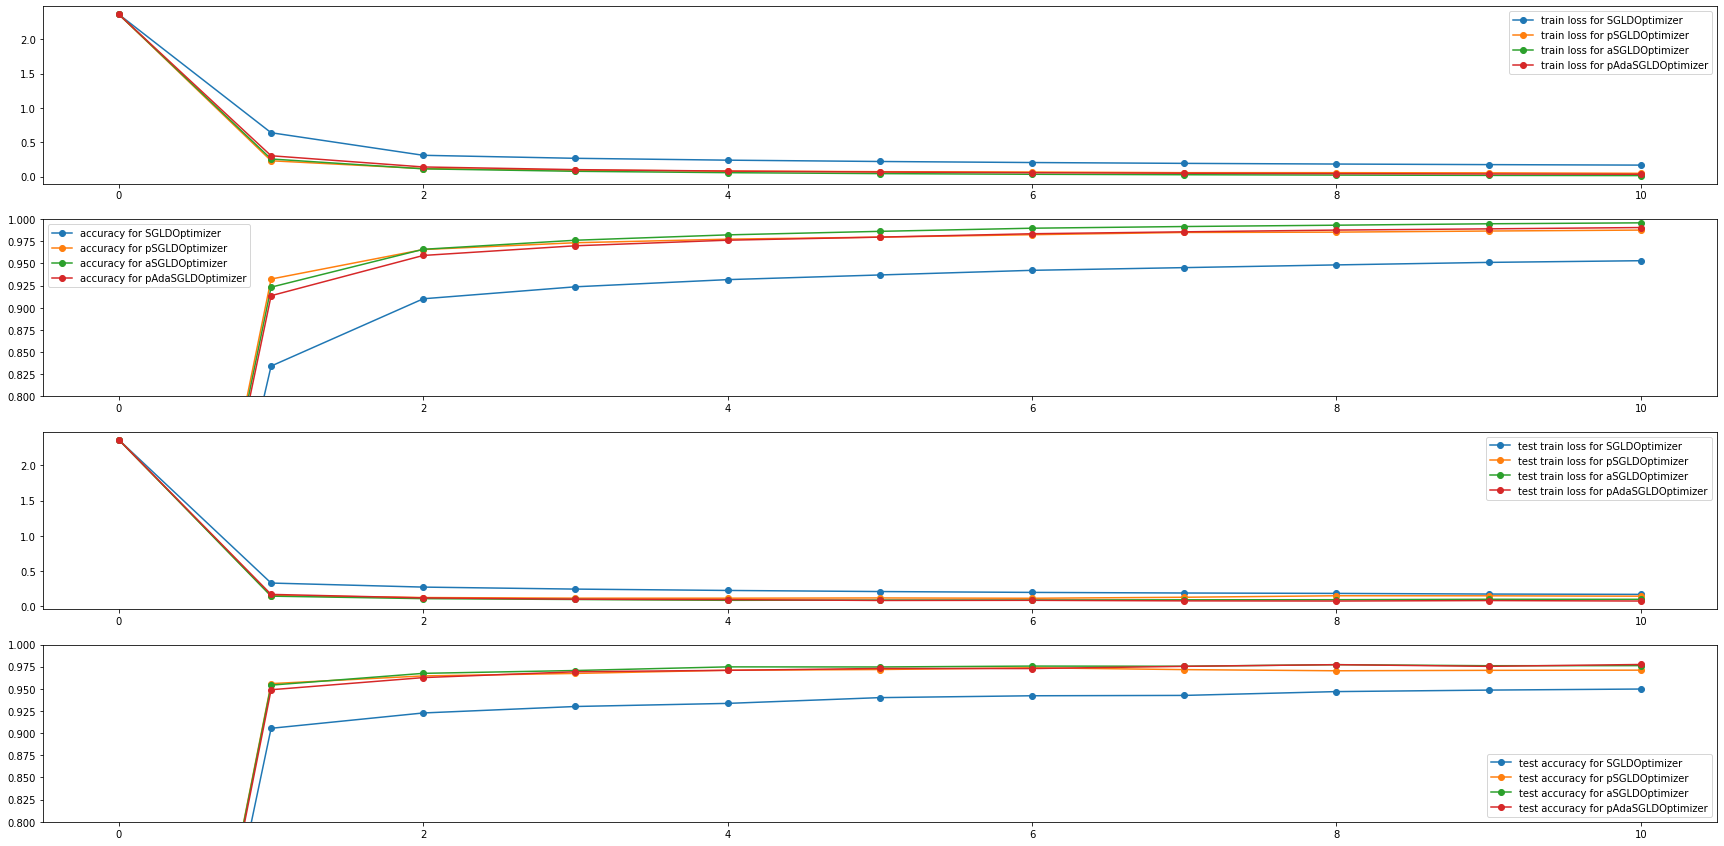

In [6]:
plt.rcParams['figure.figsize'] = [30, 15]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
for optimizer in optimizers:
    ax1.plot([eval_train_init[0]]+histories[optimizer].history['loss'], marker='o', label='train loss for {}'.format(type(optimizer).__name__))
    ax1.legend()
    ax2.plot([eval_train_init[1]]+histories[optimizer].history['accuracy'], marker='o', label='accuracy for {}'.format(type(optimizer).__name__))
    ax2.legend()
    ax2.set_ylim([0.8,1])
    ax3.plot([eval_test_init[0]]+histories[optimizer].history['val_loss'], marker='o', label='test train loss for {}'.format(type(optimizer).__name__))
    ax3.legend()
    ax4.plot([eval_test_init[1]]+histories[optimizer].history['val_accuracy'], marker='o', label='test accuracy for {}'.format(type(optimizer).__name__))
    ax4.legend()
    ax4.set_ylim([0.8,1])

plt.show()

<h3>Side by side comparision of optimization algorithm along with their Langevin version for the training of a deep neural network<h3/>

Define the model of a deep neural network and the optimizers.

In [7]:
def get_model(optimizer):
    list = 20*[32]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for nb in list:
        model.add(tf.keras.layers.Dense(nb, activation='relu'))
    model.add(tf.keras.layers.Dense(10))
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

sigma_schedule = InverseRLogDecay(
    initial_learning_rate=0.001, decay_steps=epoch_change*STEPS_PER_EPOCH, decay_rate=1., staircase=False, name=None)

optimizers = [aSGLDOptimizer(learning_rate=lr_schedule1, sigma=0.0, beta_1=0.95, beta_2=0.999, diagonal_bias=1e-6),
              aSGLDOptimizer(learning_rate=lr_schedule1, sigma=sigma_schedule, beta_1=0.95, beta_2=0.999, diagonal_bias=1e-6),
             ]

As before, train the model and plot the results. 

Finished training for optimizer aSGLDOptimizer
Finished training for optimizer aSGLDOptimizer


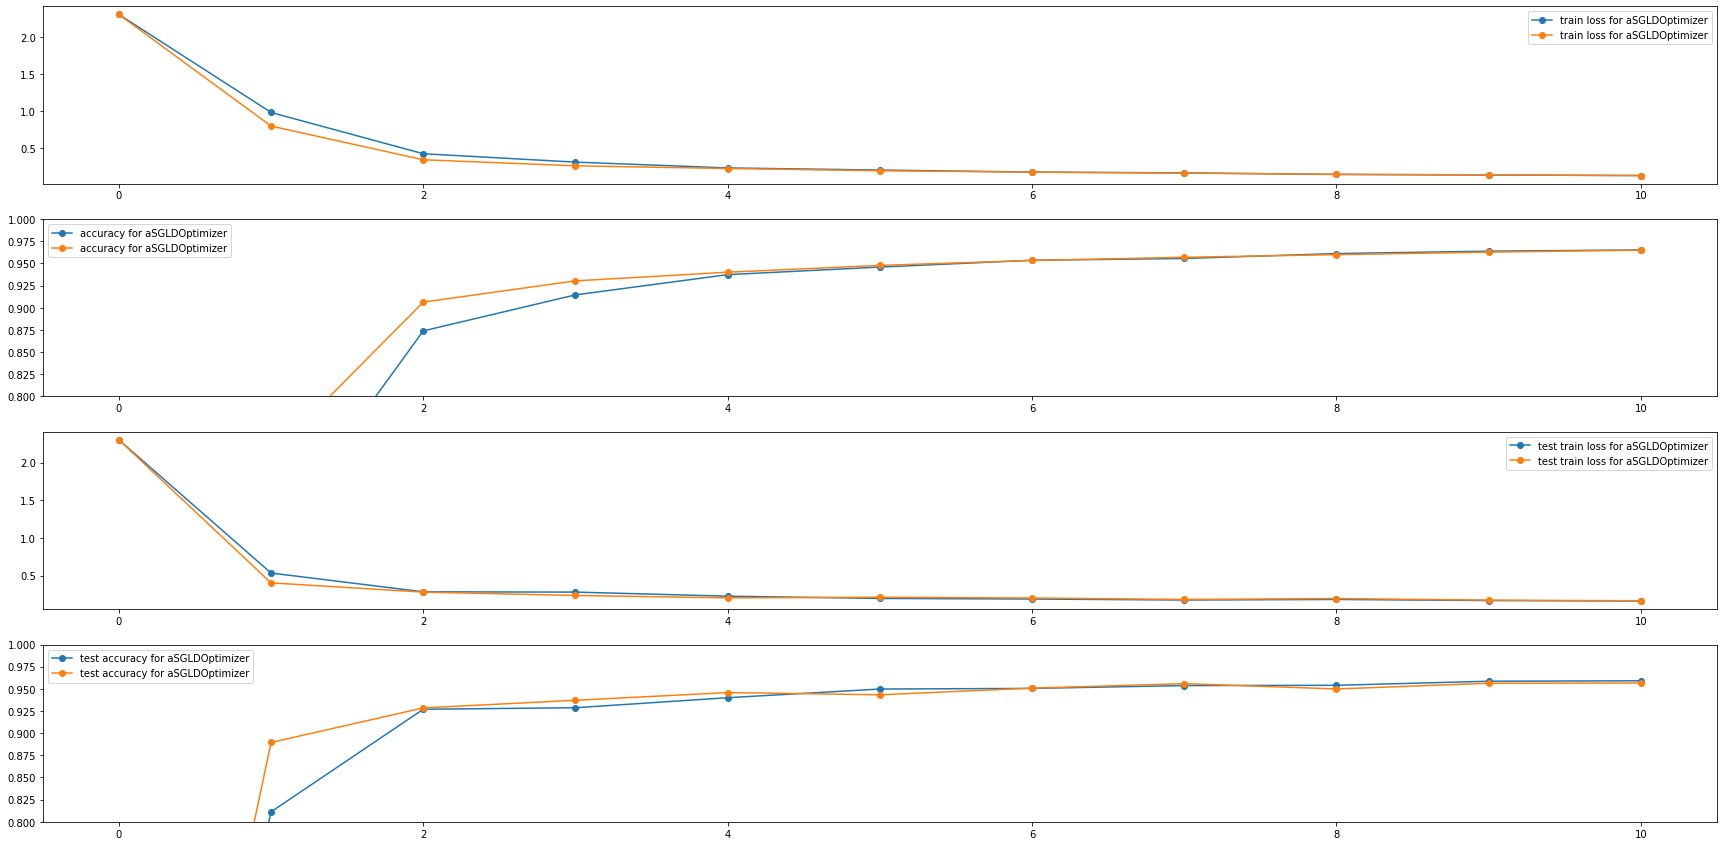

In [8]:
model = get_model('adam')
eval_train_init = model.evaluate(x_train, y_train, batch_size=32, verbose=0)
eval_test_init = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
model.save_weights('./MNIST_intial_checkpoint')

EPOCHS = 10
models = {}
histories = {}
val_histories = {}
for optimizer in optimizers:
    models[optimizer] = get_model(optimizer)
    models[optimizer].load_weights('./MNIST_intial_checkpoint')
    histories[optimizer] = models[optimizer].fit(x_train, y_train, batch_size=batch_size, epochs=EPOCHS,
                  validation_data=(x_test, y_test), verbose=0)
    print('Finished training for optimizer {}'.format(type(optimizer).__name__))

plt.rcParams['figure.figsize'] = [30, 15]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
for optimizer in optimizers:
    ax1.plot([eval_train_init[0]]+histories[optimizer].history['loss'], marker='o', label='train loss for {}'.format(type(optimizer).__name__))
    ax1.legend()
    ax2.plot([eval_train_init[1]]+histories[optimizer].history['accuracy'], marker='o', label='accuracy for {}'.format(type(optimizer).__name__))
    ax2.legend()
    ax2.set_ylim([0.8,1])
    ax3.plot([eval_test_init[0]]+histories[optimizer].history['val_loss'], marker='o', label='test train loss for {}'.format(type(optimizer).__name__))
    ax3.legend()
    ax4.plot([eval_test_init[1]]+histories[optimizer].history['val_accuracy'], marker='o', label='test accuracy for {}'.format(type(optimizer).__name__))
    ax4.legend()
    ax4.set_ylim([0.8,1])

plt.show()

<h3>Comparing the performances at the beginning of the training with poor initialization</h3>

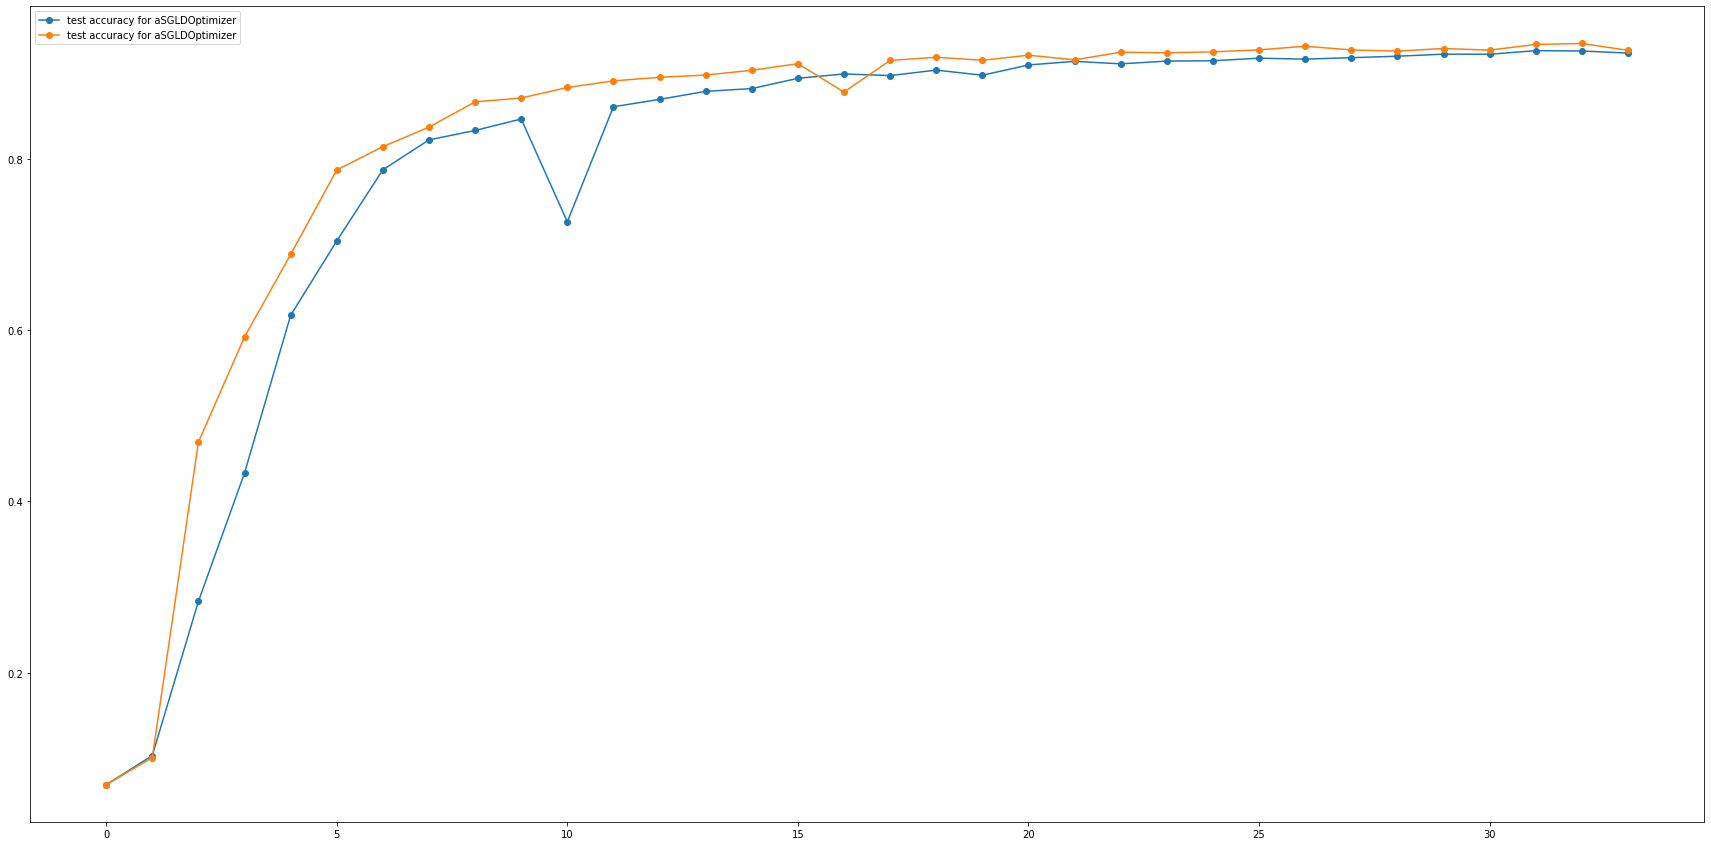

In [9]:
def initialize_to_zero(model):
    for layer in model.layers:
        zeros = [tf.zeros(tf.shape(weight)) for weight in layer.weights]
        layer.set_weights(zeros)

# evaluate the performance of the model with null weights
model = get_model('adam')
initialize_to_zero(model)
eval_test_init = model.evaluate(x_test, y_test, batch_size=32, verbose=0)

K=10 # number of times to record per epoch
batch_size=32
EPOCHS = 3
models = {}
val_histories = {}
for optimizer in optimizers:
    models[optimizer] = get_model(optimizer)
    initialize_to_zero(models[optimizer])
    val_logger = NBatchValLogger(len(x_train)//(K*batch_size), models[optimizer], x_test, y_test)
    models[optimizer].fit(x_train, y_train, batch_size=batch_size, epochs=EPOCHS,
                  validation_data=(x_test, y_test), verbose=0, callbacks=[val_logger])
    val_histories[optimizer] = val_logger

    
plt.rcParams['figure.figsize'] = [30, 15]
for optimizer in optimizers:
    plt.plot([eval_test_init[1]]+val_histories[optimizer].history['val_accuracy'], marker='o', label='test accuracy for {}'.format(type(optimizer).__name__))
plt.legend()
plt.show()